In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest

In [2]:
# Load model and data
model = joblib.load("models/final_model.pkl")  # or model_vX.pkl
df = pd.read_csv("data/prediction_log.csv")

# Format inputs
X = df[["ECG1", "ECG2"]].values

# Get scores
df["anomaly_score"] = model.decision_function(X)

In [3]:
df.head()

,timestamp,ECG1,ECG2,label,anomaly_score
0,0.703125,-0.115,-0.055,Normal,0.127357
1,0.710938,-0.155,-0.045,Normal,0.127357
2,0.718750,-0.105,-0.065,Normal,0.127357
3,0.726562,-0.125,-0.045,Normal,0.127357
4,0.734375,-0.135,-0.035,Normal,0.139074


In [4]:
# Simulated ground truth using string labels (2% anomalies)
true_labels = ['Anomaly' if i < int(0.02 * len(df)) else 'Normal' for i in range(len(df))]
df['true_label'] = true_labels

# Classification report
print("Evaluation Report (based on simulated labels):\n")
print(classification_report(df['true_label'], df['label'], target_names=["Normal", "Anomaly"]))

# Confusion matrix
cm = confusion_matrix(df['true_label'], df['label'], labels=["Normal", "Anomaly"])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.yticks([0, 1], ["Normal", "Anomaly"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar()
plt.tight_layout()
plt.savefig("results/confusion_matrix.png")
plt.close()

Evaluation Report (based on simulated labels):

              precision    recall  f1-score   support

      Normal       0.01      0.12      0.03       598
     Anomaly       0.98      0.83      0.90     29312

    accuracy                           0.81     29910
   macro avg       0.50      0.47      0.46     29910
weighted avg       0.96      0.81      0.88     29910



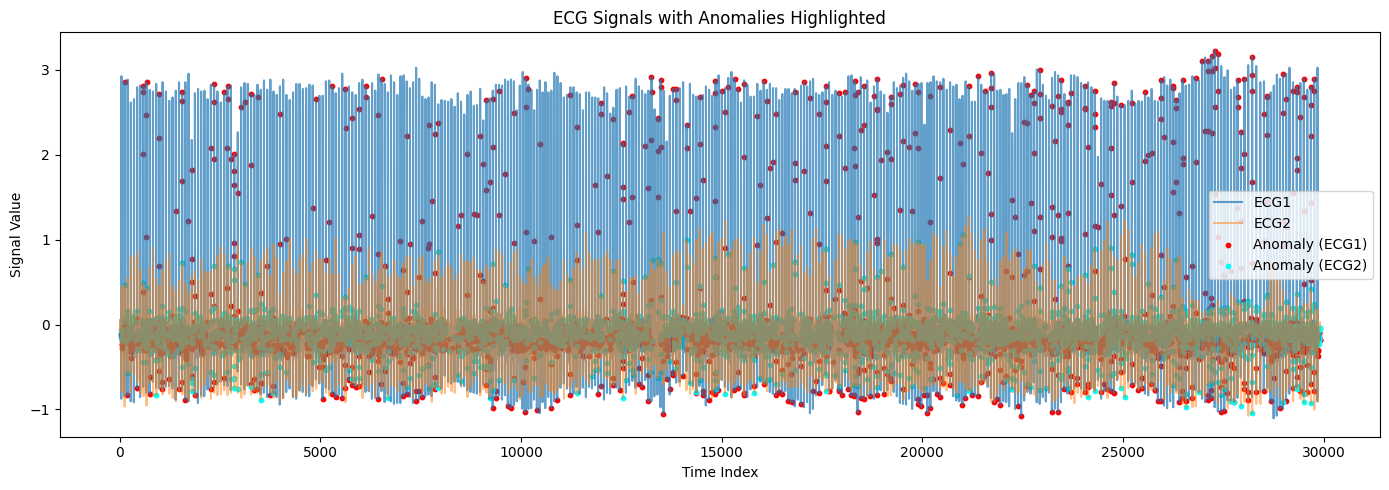

In [5]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["ECG1"], label="ECG1", alpha=0.7)
plt.plot(df.index, df["ECG2"], label="ECG2", alpha=0.5)

anomalies = df[df["label"] == "Anomaly"]
plt.scatter(anomalies.index, anomalies["ECG1"], color='red', label="Anomaly (ECG1)", s=10)
plt.scatter(anomalies.index, anomalies["ECG2"], color='cyan', label="Anomaly (ECG2)", s=10)

plt.title("ECG Signals with Anomalies Highlighted")
plt.xlabel("Time Index")
plt.ylabel("Signal Value")
plt.legend()
plt.tight_layout()
plt.savefig("results/ECG Signals with Anomalies Highlighted.png")

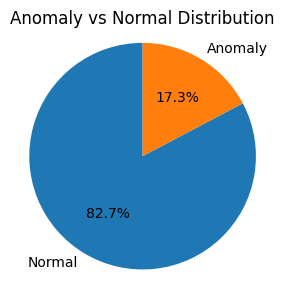

In [6]:
# Count occurrences
label_counts = df['label'].value_counts()

# Plot
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Anomaly vs Normal Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()

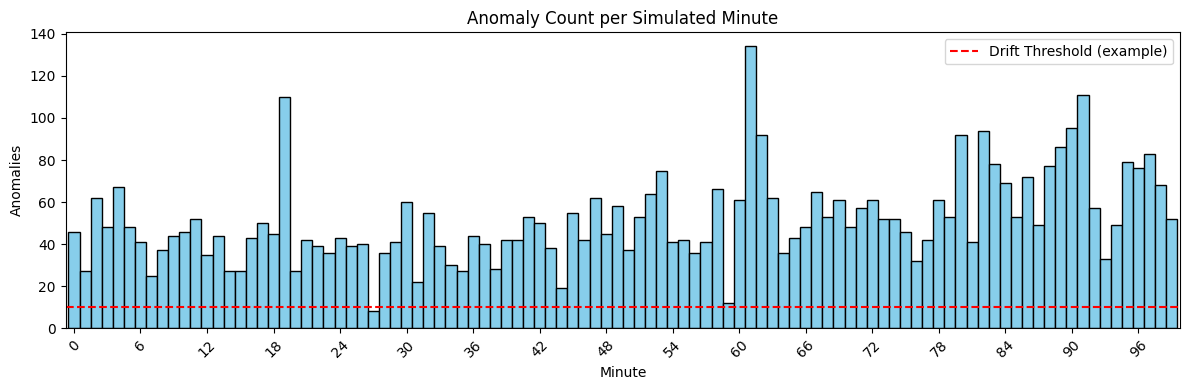

In [7]:
import matplotlib.ticker as ticker

# Simulate 'minute' as: every 300 rows = 1 minute
df['minute'] = df.index // 300

# Filter anomalies
anomalies = df[df['label'] == "Anomaly"]

# Count anomalies per minute
anomaly_counts = anomalies.groupby("minute").size()

# Plot
plt.figure(figsize=(12, 4))
ax = anomaly_counts.plot(kind='bar', width=1, color='skyblue', edgecolor='black')

plt.axhline(y=10, color='red', linestyle='--', label='Drift Threshold (example)')
plt.title("Anomaly Count per Simulated Minute")
plt.xlabel("Minute")
plt.ylabel("Anomalies")
plt.legend()

# Format x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("results/Anomaly Count per Simulated Minute.png")

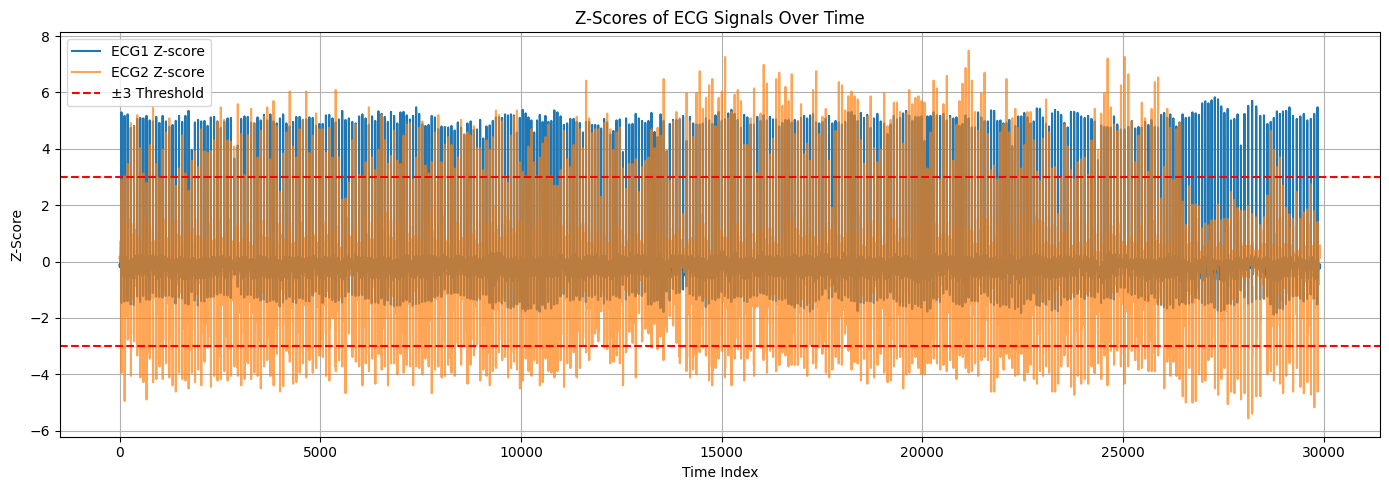

In [8]:
from scipy.stats import zscore

# Z-score per signal
df['z_ecg1'] = zscore(df['ECG1'])
df['z_ecg2'] = zscore(df['ECG2'])

# Plot z-scores over time
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['z_ecg1'], label='ECG1 Z-score')
plt.plot(df.index, df['z_ecg2'], label='ECG2 Z-score', alpha=0.7)
plt.axhline(y=3, color='red', linestyle='--', label='±3 Threshold')
plt.axhline(y=-3, color='red', linestyle='--')
plt.title("Z-Scores of ECG Signals Over Time")
plt.xlabel("Time Index")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/Z-Scores of ECG Signals Over Time.png")

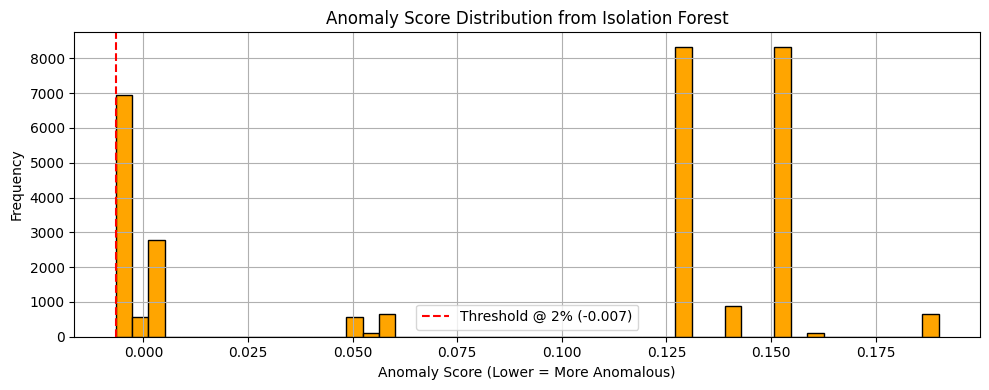

In [9]:
plt.figure(figsize=(10, 4))

# Histogram of anomaly scores
df['anomaly_score'].hist(bins=50, color='orange', edgecolor='black')
threshold = df['anomaly_score'].quantile(0.02)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold @ 2% ({threshold:.3f})')

plt.title("Anomaly Score Distribution from Isolation Forest")
plt.xlabel("Anomaly Score (Lower = More Anomalous)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("results/Distribution of Isolation Forest Anomaly Scores.png")

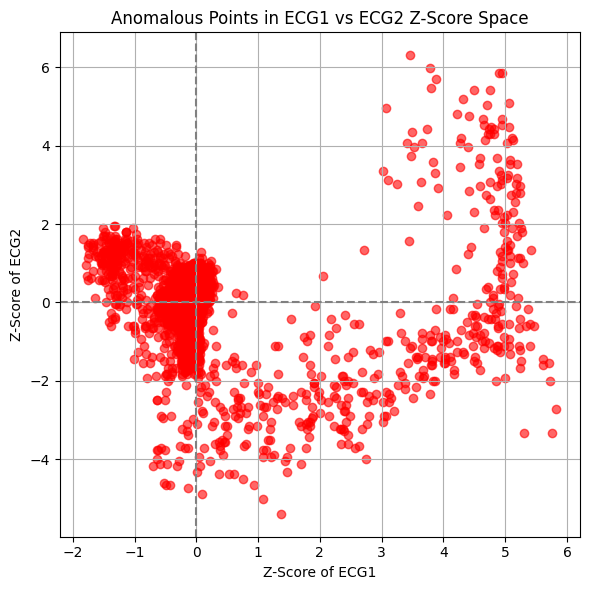

In [10]:
plt.figure(figsize=(6, 6))

# Z-score per signal
df['z_ecg1'] = zscore(df['ECG1'])
df['z_ecg2'] = zscore(df['ECG2'])

# Filter only the anomalies
anomalies = df[df["label"] == "Anomaly"]

# Scatterplot in z-score space
plt.scatter(anomalies["z_ecg1"], anomalies["z_ecg2"], color='red', alpha=0.6)

# Axes for reference
plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel("Z-Score of ECG1")
plt.ylabel("Z-Score of ECG2")
plt.title("Anomalous Points in ECG1 vs ECG2 Z-Score Space")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/Anomalous Points in Z-Score Space.png")

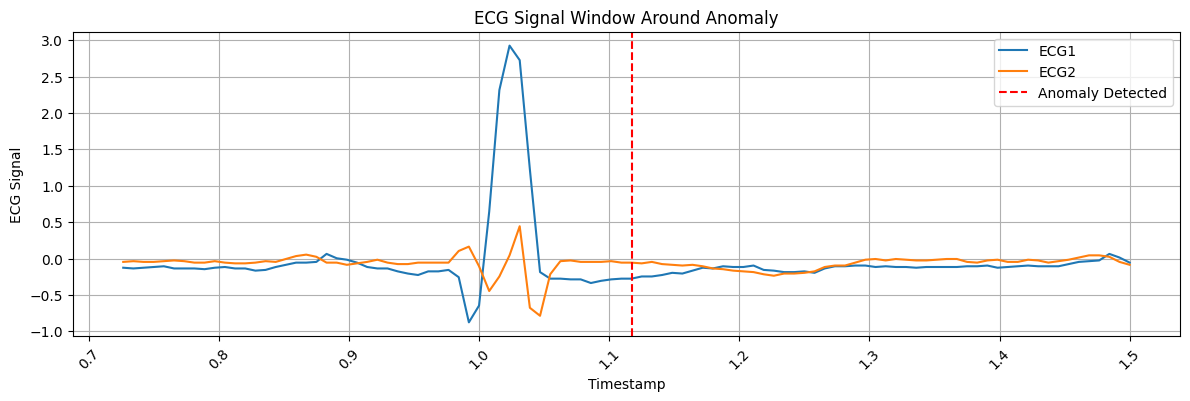

In [11]:
# Plot a window around first anomaly
first_anomaly_idx = df[df['label'] == 'Anomaly'].index[0]
window = df.iloc[first_anomaly_idx - 50:first_anomaly_idx + 50]

plt.figure(figsize=(12, 4))
plt.plot(window["timestamp"], window["ECG1"], label="ECG1")
plt.plot(window["timestamp"], window["ECG2"], label="ECG2")
plt.axvline(window["timestamp"].iloc[50], color='red', linestyle='--', label='Anomaly Detected')
plt.title("ECG Signal Window Around Anomaly")
plt.xlabel("Timestamp")
plt.ylabel("ECG Signal")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("results/ECG Signal Snippet around Anomaly.png")

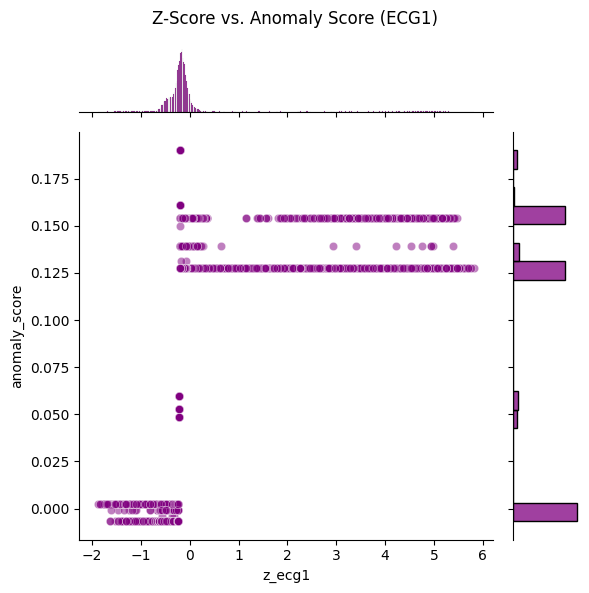

In [12]:
import seaborn as sns

sns.jointplot(data=df, x="z_ecg1", y="anomaly_score", kind="scatter", alpha=0.5, color='purple')
plt.suptitle("Z-Score vs. Anomaly Score (ECG1)")
plt.tight_layout()
plt.savefig("results/Z-Score vs Anomaly Score (ECG1).png")

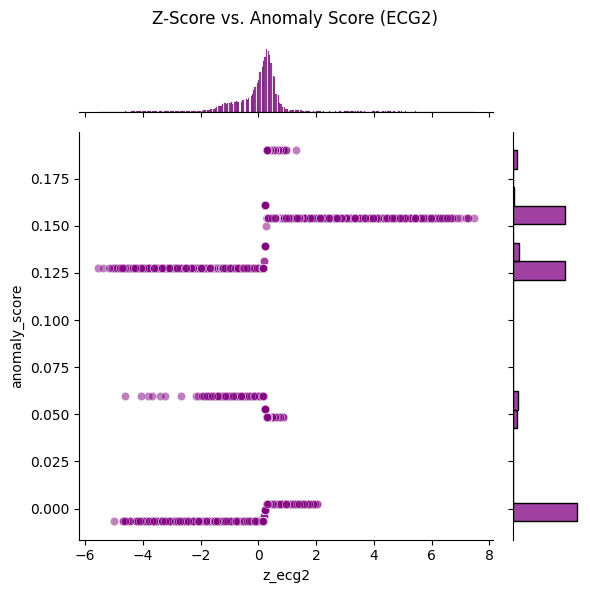

In [13]:
import seaborn as sns

sns.jointplot(data=df, x="z_ecg2", y="anomaly_score", kind="scatter", alpha=0.5, color='purple')
plt.suptitle("Z-Score vs. Anomaly Score (ECG2)")
plt.tight_layout()
plt.savefig("results/Z-Score vs Anomaly Score (ECG2).png")

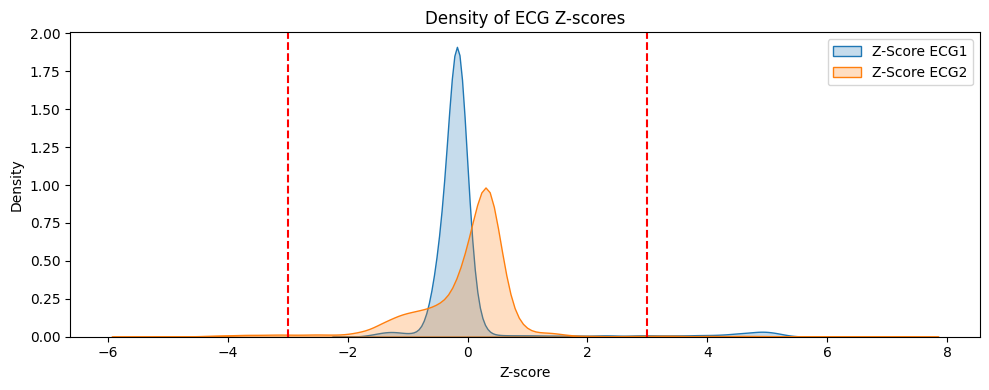

In [14]:
plt.figure(figsize=(10, 4))
sns.kdeplot(df["z_ecg1"], label="Z-Score ECG1", fill=True)
sns.kdeplot(df["z_ecg2"], label="Z-Score ECG2", fill=True)
plt.axvline(3, color='red', linestyle='--')
plt.axvline(-3, color='red', linestyle='--')
plt.title("Density of ECG Z-scores")
plt.xlabel("Z-score")
plt.legend()
plt.tight_layout()
plt.savefig("results/ECG Signal Snippet around Anomaly.png")